# Task 2

In [1]:
import matplotlib.pyplot as plt
from skimage import color
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from torchvision import transforms
from PIL import Image
from IPython.display import Audio
import torchaudio
import soundfile as sf
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

## <i>Question 1

Image Reconstruction - Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates $(X,Y)$ to the pixel colors $(R,G,B)$. Here, $(X,Y)$ represents the coordinates of the pixels, and 
$(R,G,B)$ represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.

In [6]:
img = torchvision.io.read_image("C:\\Users\\KIIT\\Pictures\\download.jpeg")
print(img.shape)

torch.Size([3, 168, 300])


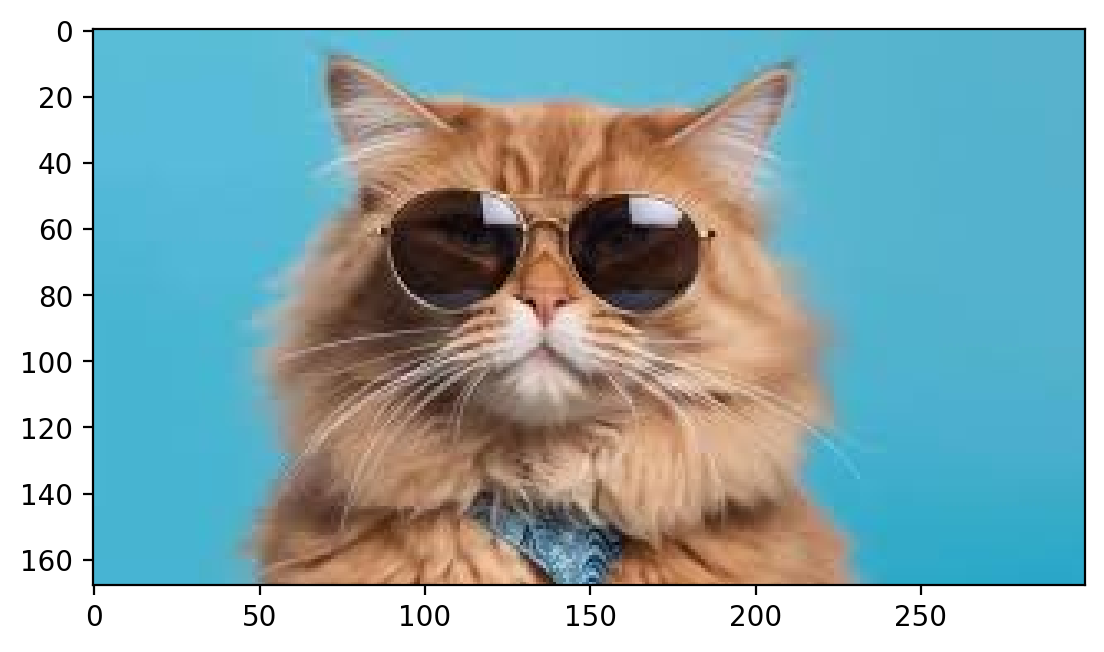

In [7]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

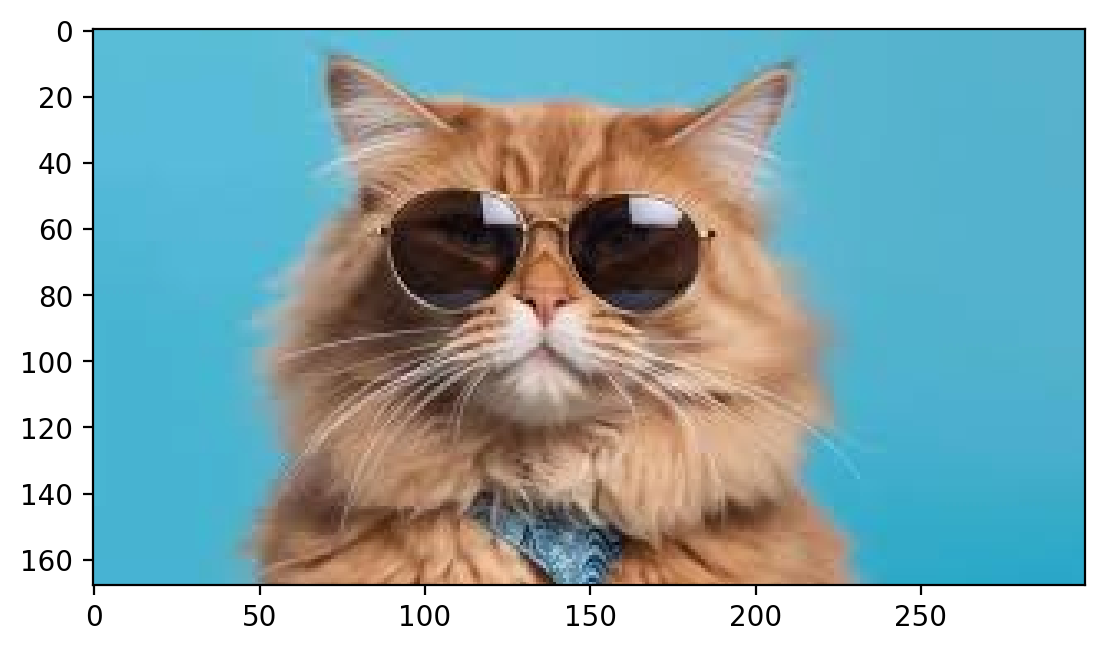

In [9]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
plt.imshow(rearrange(img_scaled, 'c h w -> h w c').numpy())

In [10]:
# Get the dimensions of the image tensor
num_channels, height, width = img_scaled.shape
print(num_channels, height, width)

3 168 300


<i>The formula for creating Random Fourier Features is given as:
$$
\phi(x) = \sqrt{\frac{2}{D}} \begin{bmatrix}
\cos(W_1 x + b_1) \\
\sin(W_1 x + b_1) \\
\vdots \\
\cos(W_D x + b_D) \\
\sin(W_D x + b_D)
\end{bmatrix}
$$

In [22]:
image1 = Image.open("C:\\Users\\KIIT\\Pictures\\download.jpeg").convert('RGB')       

image_np = np.array(image1) / 255.0

# Generate (X, Y) coordinates and (R, G, B) values
h, w, c = image_np.shape
X, Y = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
coords = np.vstack([X.ravel(), Y.ravel()]).T
colors = image_np.reshape(-1, 3)

# Random Fourier Features
def rff_mapping(X, D, gamma):
    W = np.random.normal(0, gamma, size=(X.shape[1], D))
    b = np.random.uniform(0, 2 * np.pi, size=(D,))
    return np.cos(np.dot(X, W) + b)

# Transform coordinates using RFF
D = 1000  # Number of random features
reconstructed_images2 = {}
gamma=[5,10,50,100]
for i in gamma:
    coords_rff = rff_mapping(coords, D,i)
    model_r = LinearRegression().fit(coords_rff, colors[:, 0])
    model_g = LinearRegression().fit(coords_rff, colors[:, 1])
    model_b = LinearRegression().fit(coords_rff, colors[:, 2])

    # Reconstruct image using the learned model
    reconstructed_r = model_r.predict(coords_rff)
    reconstructed_g = model_g.predict(coords_rff)
    reconstructed_b = model_b.predict(coords_rff)
    reconstructed_images2[f"reconstructed_image{i}"] = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=-1).reshape(h, w, c)


# Clamp values to [0, 1]
reconstructed_image5 = np.clip(reconstructed_images2["reconstructed_image5"], 0, 1)
reconstructed_image10 = np.clip(reconstructed_images2["reconstructed_image10"], 0, 1)
reconstructed_image50 = np.clip(reconstructed_images2["reconstructed_image50"], 0, 1)
reconstructed_image100 = np.clip(reconstructed_images2["reconstructed_image100"], 0, 1)


In [23]:
#for 3000 number of features
reconstructed_images={}
gamma=[5,10,50,100]
for i in gamma:
    coords_rff = rff_mapping(coords, 3000,i)
    model_r = LinearRegression().fit(coords_rff, colors[:, 0])
    model_g = LinearRegression().fit(coords_rff, colors[:, 1])
    model_b = LinearRegression().fit(coords_rff, colors[:, 2])

    # Reconstruct image using the learned model
    reconstructed_r = model_r.predict(coords_rff)
    reconstructed_g = model_g.predict(coords_rff)
    reconstructed_b = model_b.predict(coords_rff)
    reconstructed_images[f"reconstructed_image{i}"] = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=-1).reshape(h, w, c)


# Clamp values to [0, 1]
reconstructed_image52 = np.clip(reconstructed_images["reconstructed_image5"], 0, 1)
reconstructed_image102 = np.clip(reconstructed_images["reconstructed_image10"], 0, 1)
reconstructed_image502 = np.clip(reconstructed_images["reconstructed_image50"], 0, 1)
reconstructed_image1002 = np.clip(reconstructed_images["reconstructed_image100"], 0, 1)

<i> The formula calculating RMSE and PSNR is given as :
$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (I_{\text{orig}, i} - I_{\text{rec}, i})^2}
$$

$$
\text{PSNR} = 20 \cdot \log_{10}\left(\frac{R_{\text{max}}}{\text{RMSE}}\right)
$$

RMSE values: {5: 0.06912300666289475, 10: 0.06122172004824377, 50: 0.11212871880160803, 100: 0.19094580803259678}
PSNR values: {5: 23.207547589777462, 10: 24.26188945786841, 50: 19.005662802571685, 100: 14.381797431154485} dB


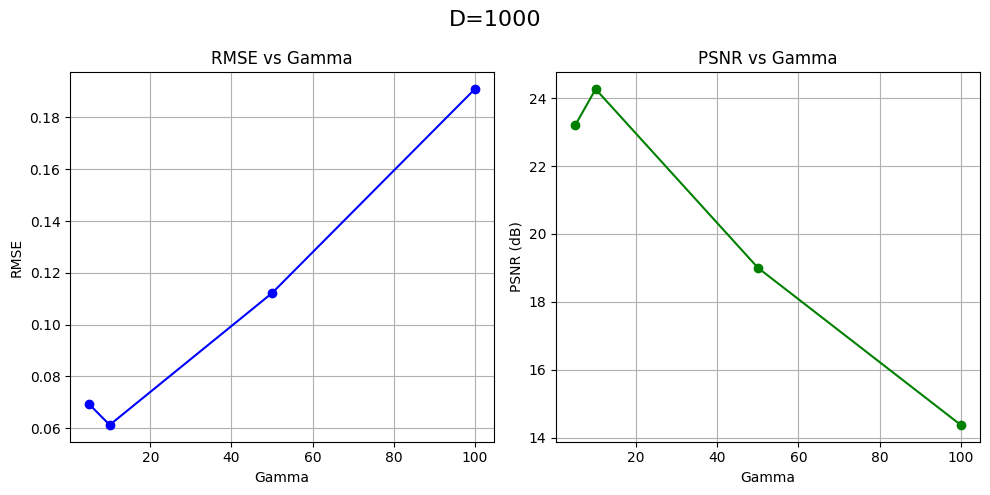

RMSE values: {5: 0.06645610594137079, 10: 0.05763881747383867, 50: 0.04288881148873462, 100: 0.14821090425860403}
PSNR values: {5: 23.54930220418609, 10: 24.7856987562778, 50: 27.353119770502282, 100: 16.582396860314734} dB


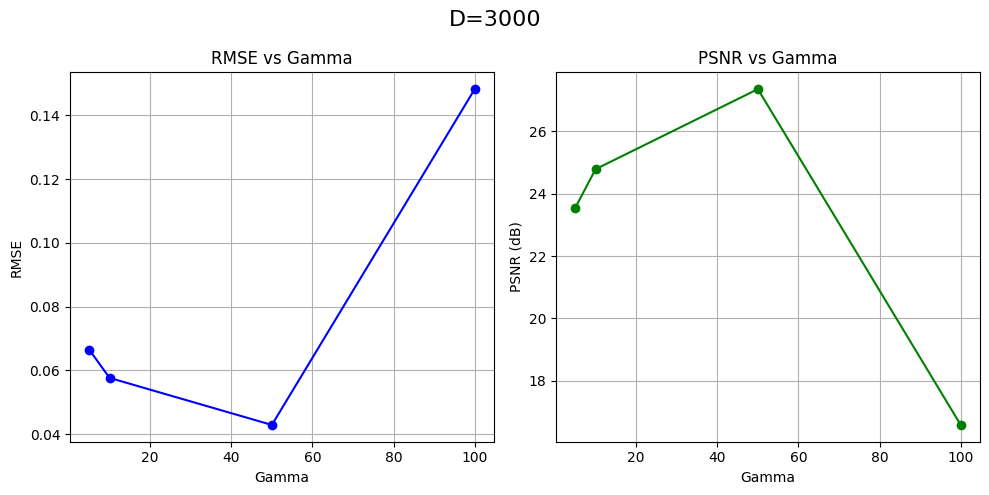

In [24]:
rmseg = {}
psnrg = {}

for i in [5, 10, 50, 100]:
    rmseg[i] = np.sqrt(mse(image_np, reconstructed_images2[f"reconstructed_image{i}"]))
    psnrg[i] = psnr(image_np, reconstructed_images2[f"reconstructed_image{i}"])

# Print metrics
print(f'RMSE values: {rmseg}')
print(f'PSNR values: {psnrg} dB')


keys = [5, 10, 50, 100]
rmse_values = [rmseg[key] for key in keys]
psnr_values = [psnrg[key] for key in keys]

# Create a new figure
plt.figure(figsize=(10, 5))
plt.suptitle('D=1000', fontsize=16)
# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(keys, rmse_values, marker='o', color='b', label='RMSE')
plt.title('RMSE vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('RMSE')
plt.grid(True)

# Plot PSNR
plt.subplot(1, 2, 2)
plt.plot(keys, psnr_values, marker='o', color='g', label='PSNR')
plt.title('PSNR vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('PSNR (dB)')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

for i in [5, 10, 50, 100]:
    rmseg[i] = np.sqrt(mse(image_np, reconstructed_images[f"reconstructed_image{i}"]))
    psnrg[i] = psnr(image_np, reconstructed_images[f"reconstructed_image{i}"])

# Print metrics
print(f'RMSE values: {rmseg}')
print(f'PSNR values: {psnrg} dB')


keys = [5, 10, 50, 100]
rmse_values = [rmseg[key] for key in keys]
psnr_values = [psnrg[key] for key in keys]

# Create a new figure
plt.figure(figsize=(10, 5))
plt.suptitle('D=3000', fontsize=16)
# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(keys, rmse_values, marker='o', color='b', label='RMSE')
plt.title('RMSE vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('RMSE')
plt.grid(True)

# Plot PSNR
plt.subplot(1, 2, 2)
plt.plot(keys, psnr_values, marker='o', color='g', label='PSNR')
plt.title('PSNR vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('PSNR (dB)')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

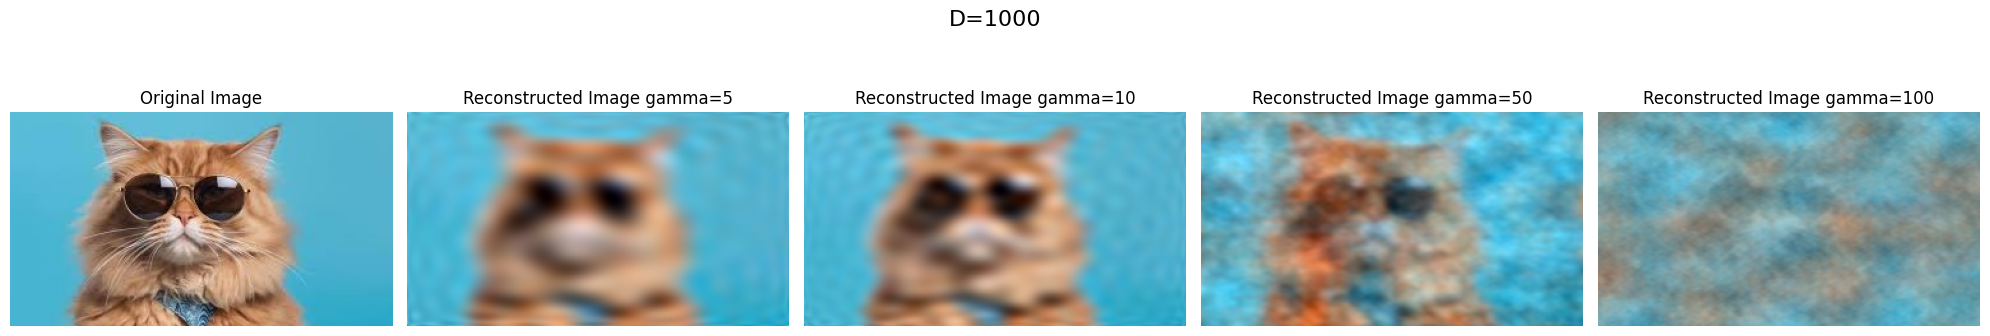

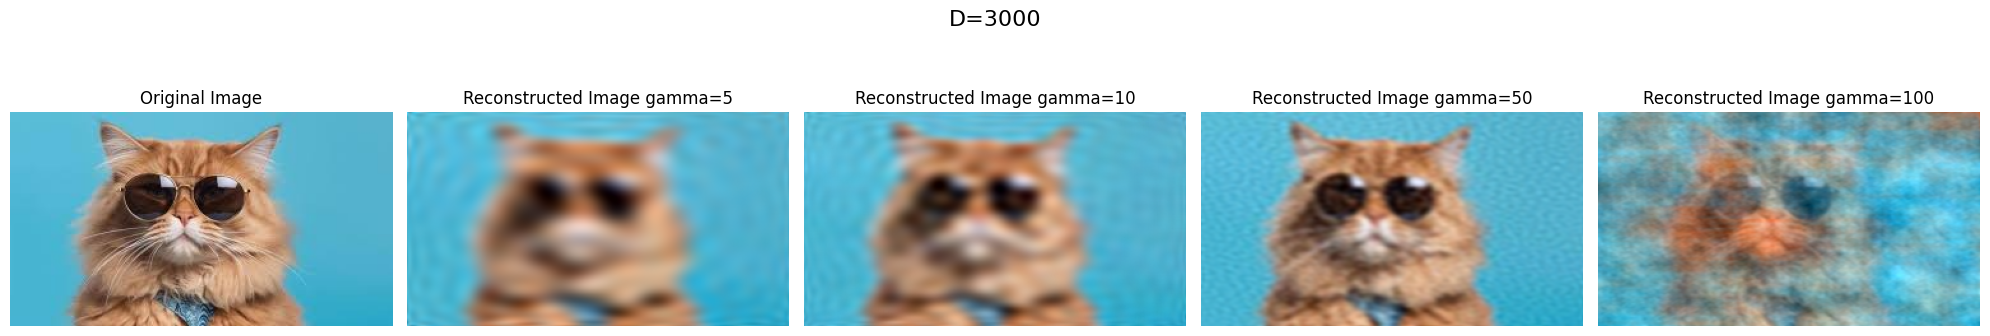

In [25]:
# Display images
plt.figure(figsize=(20, 4)) 
plt.suptitle('D=1000', fontsize=16)
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(image1)
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title('Reconstructed Image gamma=5')
plt.imshow(reconstructed_image5)
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title('Reconstructed Image gamma=10')
plt.imshow(reconstructed_image10)
plt.axis('off')

plt.subplot(1, 5, 4)
plt.title('Reconstructed Image gamma=50')
plt.imshow(reconstructed_image50)
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title('Reconstructed Image gamma=100')
plt.imshow(reconstructed_image100)
plt.axis('off')

plt.tight_layout() 
plt.show()

# Display images
plt.figure(figsize=(20, 4))
plt.suptitle('D=3000', fontsize=16)
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(image1)
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title('Reconstructed Image gamma=5')
plt.imshow(reconstructed_image52)
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title('Reconstructed Image gamma=10')
plt.imshow(reconstructed_image102)
plt.axis('off')

plt.subplot(1, 5, 4)
plt.title('Reconstructed Image gamma=50')
plt.imshow(reconstructed_image502)
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title('Reconstructed Image gamma=100')
plt.imshow(reconstructed_image1002)
plt.axis('off')

plt.tight_layout()
plt.show()


## <i>Question 2 

Audio Reconstruction - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time $(t)$ to amplitude $(A)$, where $t$ is the time point, and $A$ is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction.

Audio shape: torch.Size([220500]), Sampling rate: 44100


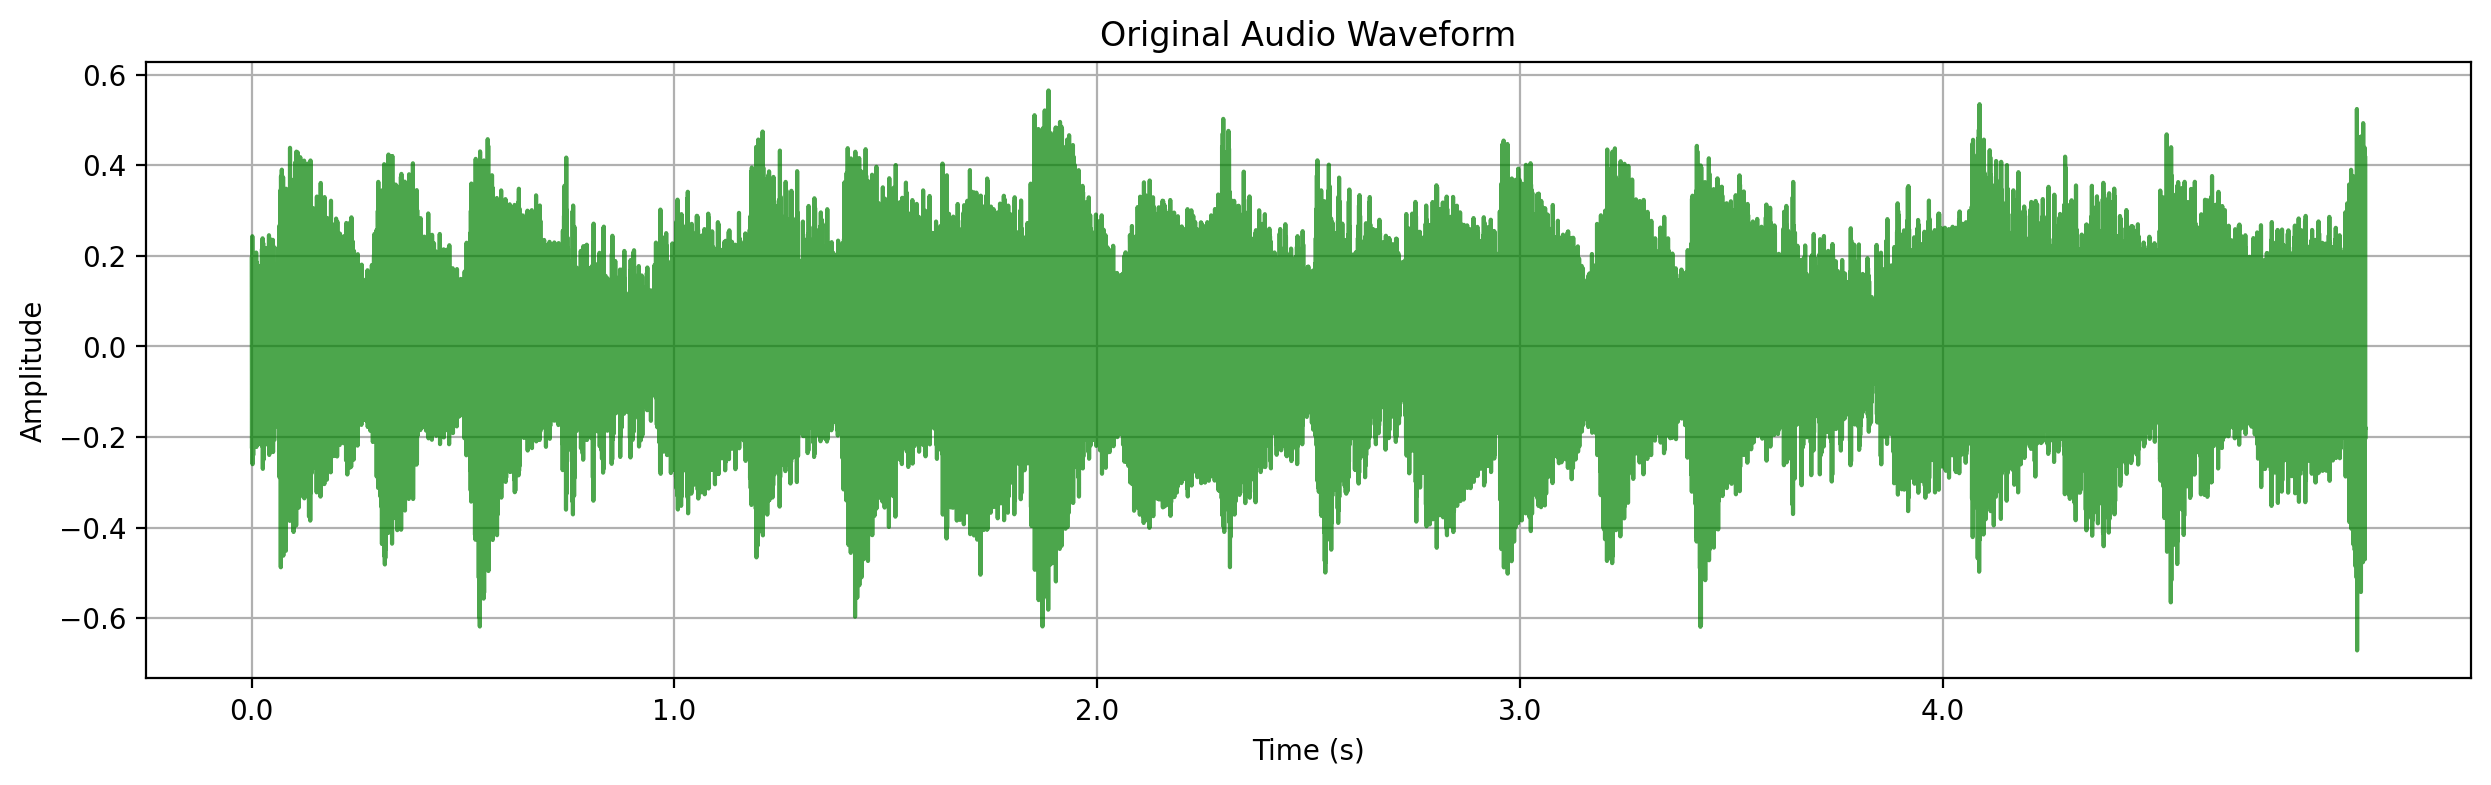

RFF shape: torch.Size([220500, 5000])


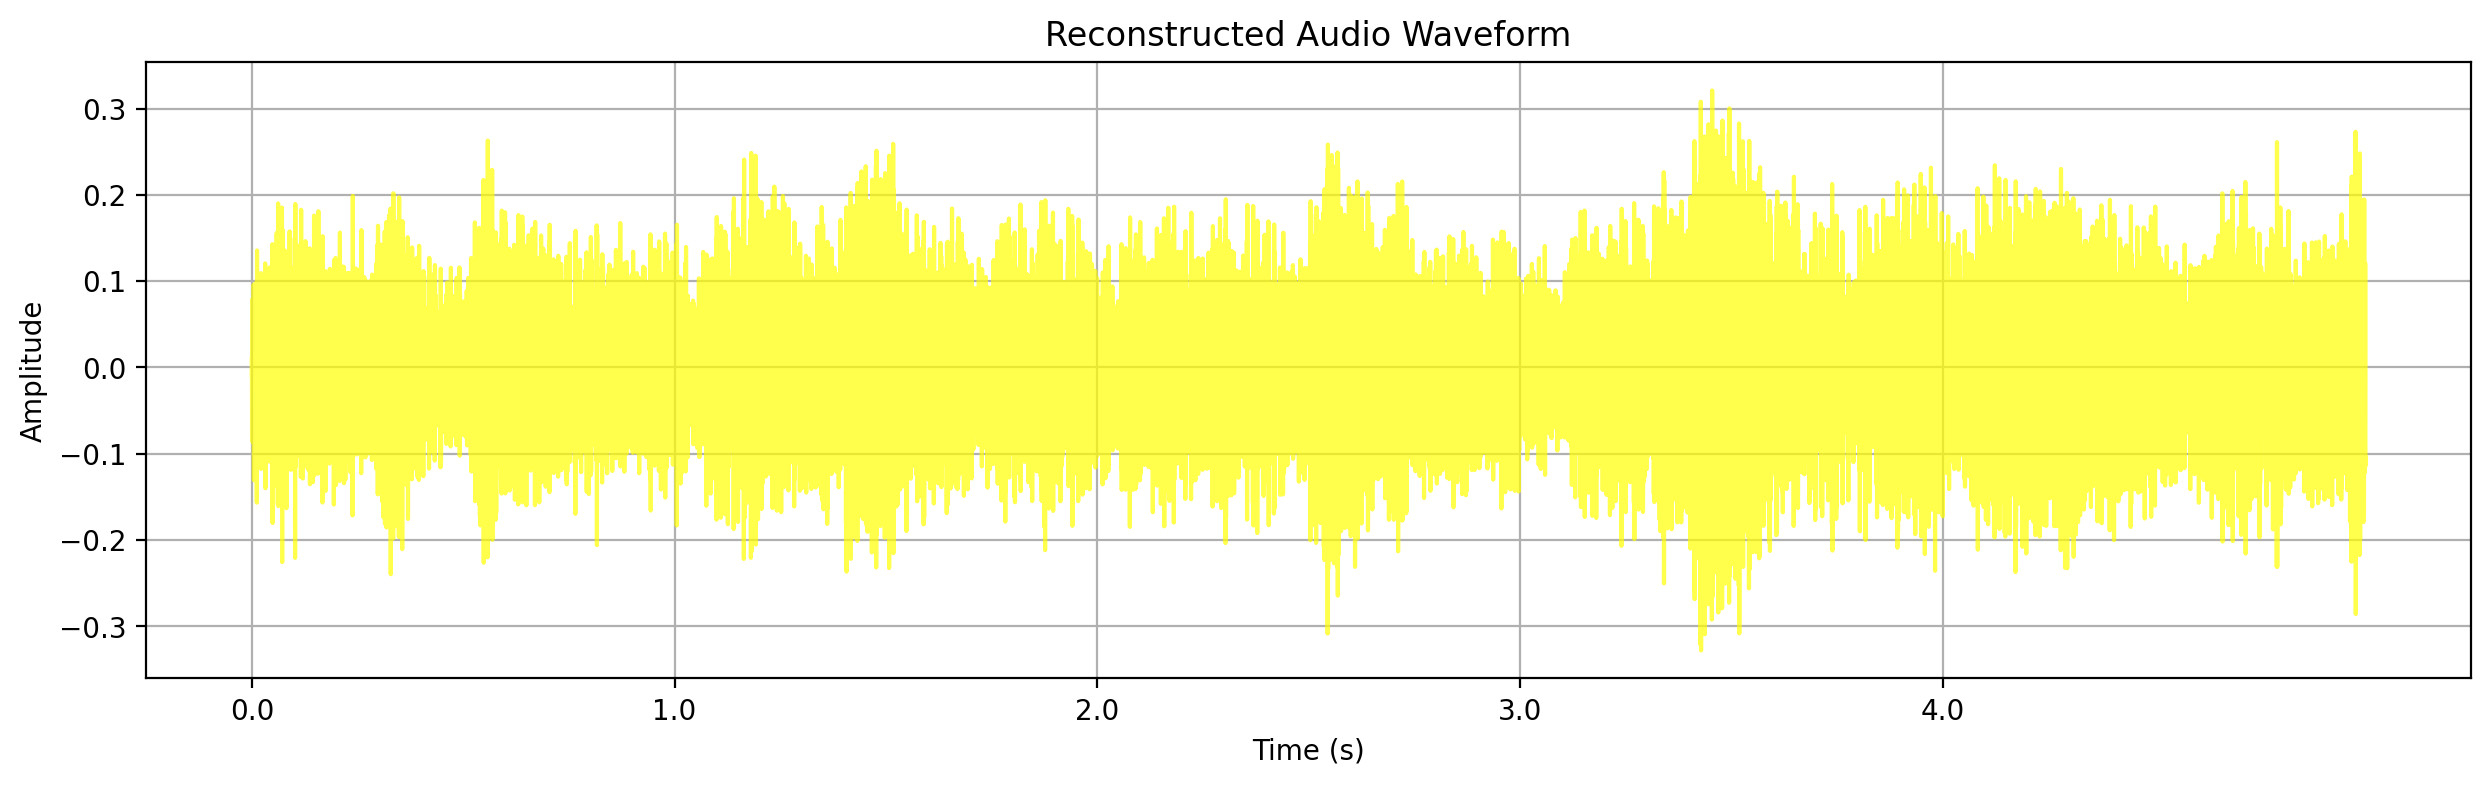

RMSE: 0.1398
SNR: 1.08 dB


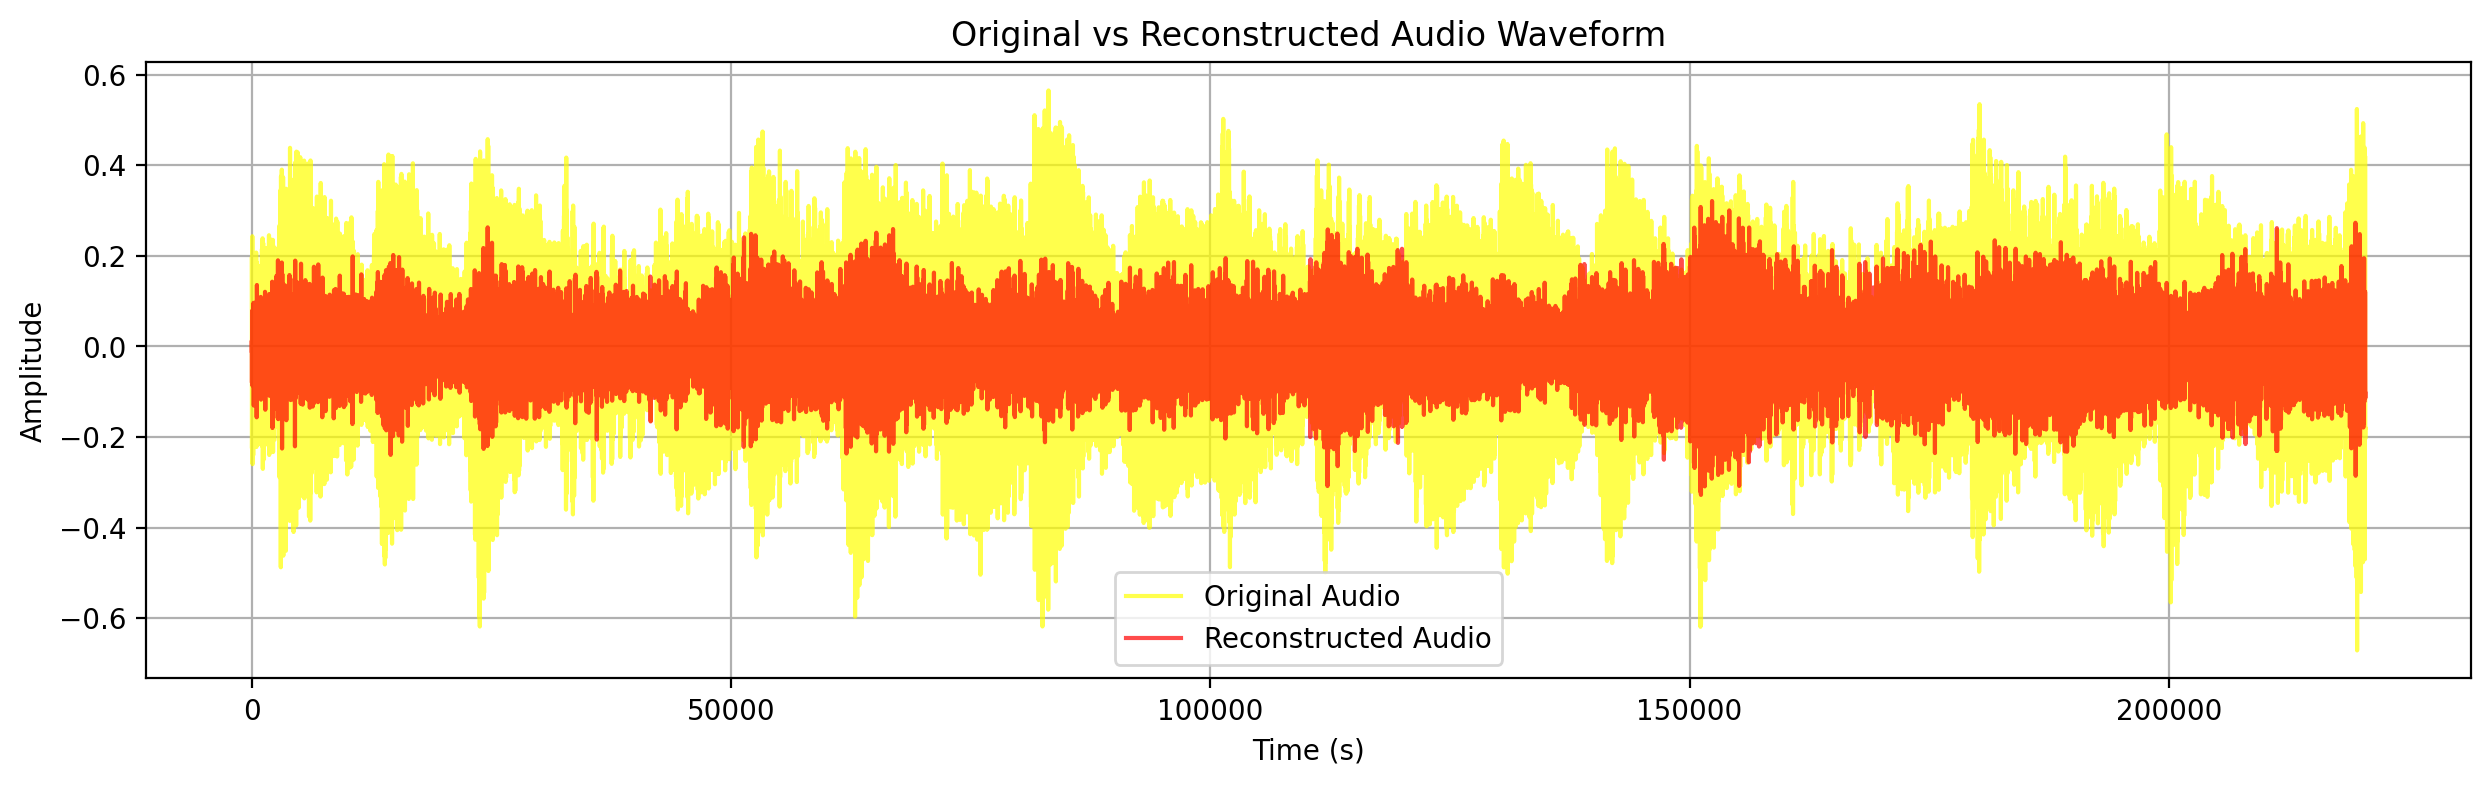

In [3]:
audio, sr = torchaudio.load("C:\\Users\\KIIT\\Downloads\\WhatsApp Audio 2024-09-17 at 21.03.30_8482e999.mp3")

# Only take the first channel for mono audio
audio = audio[0]

# Normalize audio to [-1, 1]
audio = audio / torch.max(torch.abs(audio))

# Ensure we are working with a 5-second audio sample
audio = audio[2*sr:7 * sr]
print(f"Audio shape: {audio.shape}, Sampling rate: {sr}")

# Create time domain shifted to [-100, 100]
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100

# Plot the original audio waveform
def audio_plot(audio, sr, color, title):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color=color, alpha=0.7)
    plt.xticks(np.arange(0, len(audio), sr), np.arange(0, len(audio) / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid()
    plt.show()

audio_plot(audio, sr, 'green', 'Original Audio Waveform')

# Random Fourier Features mapping function
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma ** 2), random_state=13)
    X_rff = rff.fit_transform(X.numpy())
    return torch.tensor(X_rff, dtype=torch.float32)

# Generate Random Fourier Features
num_features = 5000
sigma = 0.008
X_rff = create_rff_features(X, num_features, sigma)
print(f"RFF shape: {X_rff.shape}")

# Fit a Linear Model on the Random Fourier Features
model = LinearRegression()
model.fit(X_rff.numpy(), audio.numpy())

# Reconstruct the audio using the model
pred_audio = model.predict(X_rff.numpy())
pred_audio = torch.tensor(pred_audio)

# Save the reconstructed audio
sf.write('pred_audio.wav', pred_audio.numpy(), sr)

# Plot the reconstructed audio waveform
audio_plot(pred_audio, sr, 'yellow', 'Reconstructed Audio Waveform')

# Play the original and reconstructed audio
display(Audio(audio.numpy(), rate=sr))
display(Audio(pred_audio.numpy(), rate=sr))

# Compute and display reconstruction metrics (RMSE, SNR)
rmse = np.sqrt(np.mean((audio.numpy() - pred_audio.numpy()) ** 2))
snr = 10 * np.log10(np.mean(audio.numpy() ** 2) / np.mean((audio.numpy() - pred_audio.numpy()) ** 2))

print(f'RMSE: {rmse:.4f}')
print(f'SNR: {snr:.2f} dB')

# Plot comparison between original and reconstructed audio
plt.figure(figsize=(15, 4))
plt.plot(audio.numpy(), color='yellow', alpha=0.7, label='Original Audio')
plt.plot(pred_audio.numpy(), color='red', alpha=0.7, label='Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()
